# Limit order book (LOB) simulation

The simulation of financial markets through the use of agent-based models is an increasingly popular technique to understand the microstructure of their dynamics from the bottom up. See, for some examples:

- [Raberto et al. (2001)](https://www.sciencedirect.com/science/article/abs/pii/S0378437101003120?via%3Dihub) is a basic model of a financial market with constant total cash being conserved.
- [Alfarano, Lux & Wagner (2005)](https://link.springer.com/article/10.1007/s10614-005-6415-1) details the construction of a market microsimulation with asymmetric herding to explain the fat tails in the distribution of returns while also showing how it follows a Fokker-Planck equation up to second-order corrections.
- [Smith et al. (2006)](https://www.tandfonline.com/doi/abs/10.1088/1469-7688/3/6/307) is the original Santa Fe model for LOB simulations.
- [Tóth et al. (2011)](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.1.021006) extends the original Santa Fe models to become '$\epsilon$-intelligence' models.
- [Mastromatteo, Tóth & Bouchaud (2014)](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.89.042805) develops the $\epsilon$-intelligence model further by including non-unit market and limit meta-orders.
- [Chen, Tan & Zheng (2015)](https://www.nature.com/articles/srep08399) looks at multi-level herding in agent-based market simulation. This is able to maintain both sector-level structure of markets and clustering between them at the same time as their respective temporal correlation structures.
- [Bouchaud et al. (2018)](https://doi.org/10.1017/9781316659335) is a detailed textbook on market microstructure.
- [Chen et al. (2017)](https://link.springer.com/article/10.1007/s11467-017-0661-2) looks at the 'information driving force' as a way to calibrate their specific form of agent-based model empirically.
- [Marcaccioli, Bouchaud, Benzaquen (2021)](https://arxiv.org/abs/2106.07040) shows how endogenous (self-exciting) and exogeneous (driven by external factors like sudden news breaks) price jumps belong to different dynamical classes as their relaxation profiles can be inferred to be different.

In this notebook, we'll build an example LOB simulation which replicates many of the key empirical stylised facts in real-world financial markets.

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Get the class structures
import sys
sys.path.append("./src/")
from lobsim import lobsim
from agents import agentens

## A synchronous ensemble version of the $\epsilon$-intelligence model

The simulation we will design is an **individual-agent** version of the $\epsilon$-intelligence extension to the original Santa Fe model. In plate notation, where have also added blue-shaded regions to indicate when a choice of path must be taken for a given moment in time, the LOB simulation we have constructed can be summarised by the following graphs 

<img src="lob-agent-sim.png" width="500"/>

In the above model, we separate liquidity providers in the market - who place limit orders at price $p$ with rates $\lambda^B_p$ and $\lambda^A_p$ on the bid and ask side, respectively, and cancel these orders at a uniform rate of $\nu$ for each individual unit of volume - from liquidity takers - who place market orders at price $p$ for the $i$-th agent at rates $\mu^B_{pi}$ and $\mu^A_{pi}$.

## Running simulations

The model we have introduced and analysed above has been implemented in the `/src` folder of this repo using a synchronous ensemble rejection algorithm. All we need to do is call the necessary class structures and run them to see the LOB sim in action. The key point to remember for this algorithm to produce sensible results will be to make sure the overall holding rate is large enough to minimise the number of anachronisms in the order flow.

In [3]:
setup = {
    # Initial bid tick
    "initbidpricetick" : 498,
    # Initial ask tick
    "initaskpricetick" : 502,
    # The price tick size
    "tickscale" : 0.01,
    # The number of price points simulated
    "Nlattice" : 1000,
    # Number of liquidity providing agents
    "Nproviders" : 50,
    # Number of liquidity taking agents
    "Ntakers" : 50,
    # The 'alpha' parameter of the limit order aggression
    # beta distribution across agents
    "LOaggrA" : 0.5,
    # The 'beta' parameter of the limit order aggression
    # beta distribution across agents
    "LOaggrB" : 5.0,
    # The 'alpha' parameter of the market order aggression
    # beta distribution across agents
    "MOaggrA" : 5.0,
    # The 'beta' parameter of the market order aggression
    # beta distribution across agents
    "MOaggrB" : 0.5,
    # The strength of anti-correlation between market orders
    # and limit orders on the same book side for each agent 
    "LOsignalpha" : 0.5,
    # The Pareto power law value for market order volumes
    "MOvolpower" : 0.5,
    # The Pareto power law value for market order volumes
    "MOvolcutoff" : 100,
    # Mean limit order rate per agent on the bid side
    "meanLOratebid" : 4.5,
    # Mean limit order rate per agent on the ask side
    "meanLOrateask" : 4.5,
    # Mean market order rate per agent on the bid side
    "meanMOratebid" : 4.0,
    # Mean market order rate per agent on the ask side
    "meanMOrateask" : 4.0,
    # Mean cancel order rate per agent on the bid side
    "meanCOratebid" : 4.0,
    # Mean cancel order rate per agent on the ask side
    "meanCOrateask" : 4.0,
    # The overall mean holding rate
    "meanHOrate" : 10.0,
    # Limit order mean rate decay power in price units
    "meanLOdecay" : 5.0,
}

# Initialise the LOB simulation
los = lobsim(setup, agentens=agentens)

# Iterate the LOB over time
burn_in = 50.0
tend, t = 5000.0, 0.0
midps = []
while t < tend:
    los.iterate()
    t = los.time
    midps.append([t, los.market_state_info["midprice"]])

# Create time series using the mid price output data
df = pd.DataFrame(midps, columns=['Time', 'Mid price'])
df = df[df.Time > burn_in]

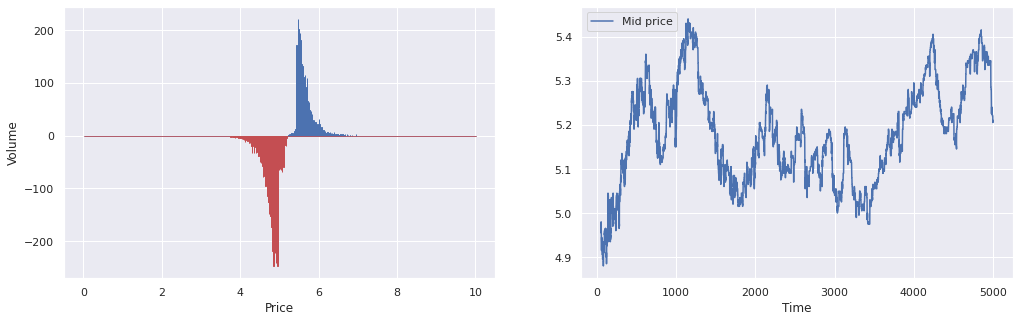

In [4]:
# Plot the LOB snapshot and mid price time series
fig, ax = plt.subplots(1, 2, figsize=(17, 5))
ax[0].bar(los.prices, los.asks, width=setup["tickscale"], edgecolor='b')
ax[0].bar(los.prices, -los.bids, width=setup["tickscale"], edgecolor='r')
df.set_index('Time').plot(ax=ax[1])
ax[0].set_ylabel('Volume')
ax[0].set_xlabel('Price')
plt.show()

/tmp/ipykernel_6470/323926846.py:19: RuntimeWarning: divide by zero encountered in log
  np.log(f[::-1]),
/tmp/ipykernel_6470/323926846.py:19: RuntimeWarning: divide by zero encountered in log
  np.log(f[::-1]),
/tmp/ipykernel_6470/323926846.py:19: RuntimeWarning: divide by zero encountered in log
  np.log(f[::-1]),
/tmp/ipykernel_6470/323926846.py:19: RuntimeWarning: divide by zero encountered in log
  np.log(f[::-1]),


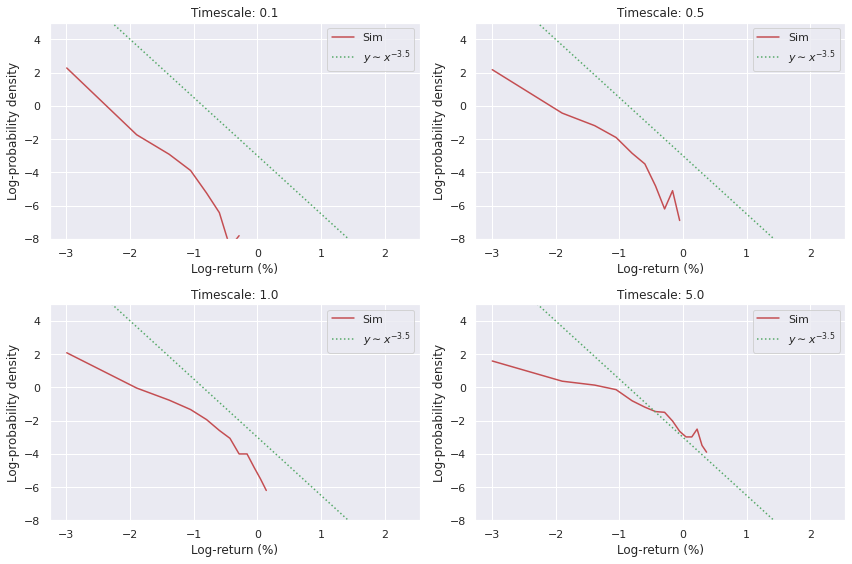

In [5]:
# Plot the distribution over returns over different time periods
dts = [0.1, 0.5, 1.0, 5.0] # Time periods 
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
axs = [ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]]
for dt, ax in zip(dts, axs):
    df_asof = df.set_index('Time').asof(
        np.arange(dt, tend, dt)
    )
    perc_returns = 100.0 * (
        df_asof.diff().shift(-1) / df_asof
    ).iloc[:-1].values
    f, b = np.histogram(
        np.abs(perc_returns),  
        density=True,
        bins=np.arange(0.0, 10.0, 0.1)
    )
    ax.plot(
        np.log(0.5*(b[1:]+b[:-1])[::-1]), 
        np.log(f[::-1]),
        color='r',
        label='Sim',
    )
    ax.plot(
        np.log(0.5*(b[1:]+b[:-1])[::-1]),
        -3.5*np.log(0.5*(b[1:]+b[:-1])[::-1]) - 3.0,
        ':',
        color='g',
        label=r'$y\sim x^{-3.5}$',
    )
    ax.legend()
    ax.set_ylim([-8.0, 5.0])
    ax.set_ylabel('Log-probability density')
    ax.set_xlabel('Log-return (%)')
    ax.set_title('Timescale: ' + str(dt))
plt.tight_layout()
plt.show()

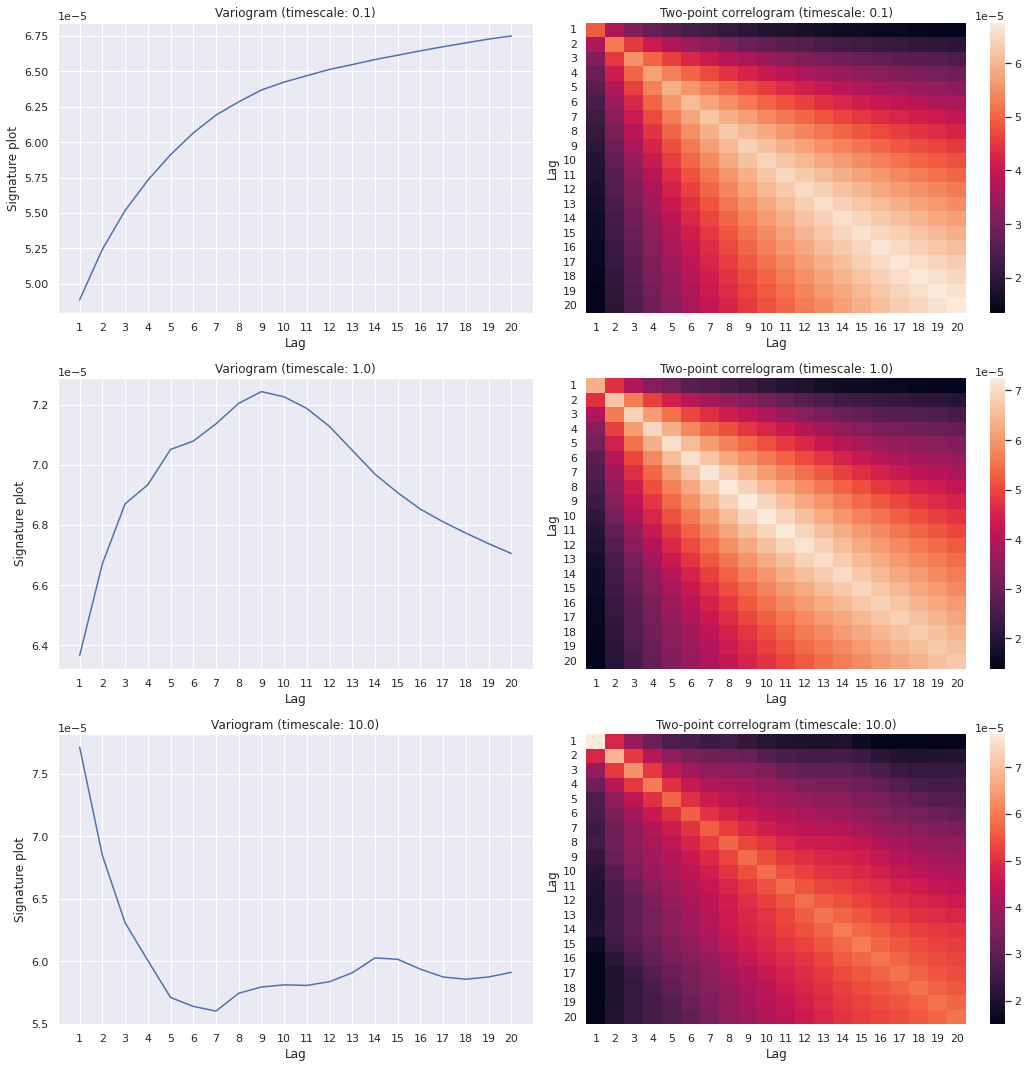

In [6]:
# Plot the variogram and cross-variogram of the price time series
nlags = 20
dts = [0.1, 1.0, 10.0] # Time periods
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
axs = [ax[0], ax[1], ax[2]]
for dt, ax in zip(dts, axs):
    df_asof = df.set_index('Time').asof(
        np.arange(dt, tend, dt)
    )
    pmsq = df_asof.mean() ** 2
    c = np.zeros(nlags)
    cc = np.zeros((nlags, nlags))
    for lag1 in range(1, nlags + 1):
        s1 = df_asof - df_asof.shift(lag1)
        s2 = df_asof - df_asof.shift(lag1)
        c[lag1-1] = (
            (s1 * s2).mean()
            / (dt * lag1)
        )
        for lag2 in range(1, nlags + 1):
            s2 = df_asof - df_asof.shift(lag2)
            cc[lag1-1, lag2-1] = (
                (s1 * s2).mean()
                / (dt * np.sqrt(lag1) * np.sqrt(lag2))
            )
    ax[0].plot(range(1, nlags + 1), c)
    sns.heatmap(cc, ax=ax[1])
    ax[0].set_xticks(range(1, nlags + 1))
    ax[1].set_xticklabels(range(1, nlags + 1))
    ax[1].set_yticklabels(range(1, nlags + 1))
    ax[0].set_xlabel('Lag')
    ax[0].set_ylabel('Signature plot')
    ax[1].set_xlabel('Lag')
    ax[1].set_ylabel('Lag')
    ax[0].set_title(
        'Variogram (timescale: ' + str(dt) + ')'
    )
    ax[1].set_title(
        'Two-point correlogram (timescale: ' + str(dt) + ')'
    )
plt.tight_layout()
plt.show()